<a href="https://colab.research.google.com/github/GitHub-Bong/NLP_study/blob/master/NLP_study%20note-4-2-Text_Generation_using_RNN%2C_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN 이용한 텍스트 생성

__다 대 일(many-to-one) 구조의 RNN 사용__

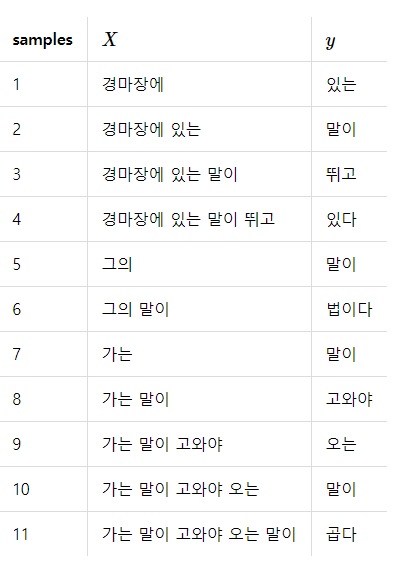

## 1) 데이터에 대한 이해와 전처리

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.utils import to_categorical

In [57]:
text="""경마장에 있는 말이 뛰고 있다\n
그의 말이 법이다\n
가는 말이 고와야 오는 말이 곱다\n"""

In [58]:
t = Tokenizer()
t.fit_on_texts([text])
vocab_size = len(t.word_index) + 1
# 케라스 토크나이저의 정수 인코딩은 인덱스가 1부터 시작하지만,
# 케라스 원-핫 인코딩에서 배열의 인덱스가 0부터 시작하기 때문에
# 배열의 크기를 실제 단어 집합의 크기보다 +1로 생성해야하므로 미리 +1 선언 
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 12


In [59]:
print(t.word_index)

{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


## 2) 훈련 데이터 


In [60]:
sequences = list()
for line in text.split('\n'): # Wn을 기준으로 문장 토큰화
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

print('학습에 사용할 샘플의 개수: %d' % len(sequences))

학습에 사용할 샘플의 개수: 11


In [61]:
print(sequences)

[[2, 3], [2, 3, 1], [2, 3, 1, 4], [2, 3, 1, 4, 5], [6, 1], [6, 1, 7], [8, 1], [8, 1, 9], [8, 1, 9, 10], [8, 1, 9, 10, 1], [8, 1, 9, 10, 1, 11]]


In [62]:
max_len=max(len(l) for l in sequences) # 모든 샘플에서 길이가 가장 긴 샘플의 길이 출력
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 6


**전체 샘플의 길이를 6으로 패딩**

In [63]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')

In [64]:
print(sequences)

[[ 0  0  0  0  2  3]
 [ 0  0  0  2  3  1]
 [ 0  0  2  3  1  4]
 [ 0  2  3  1  4  5]
 [ 0  0  0  0  6  1]
 [ 0  0  0  6  1  7]
 [ 0  0  0  0  8  1]
 [ 0  0  0  8  1  9]
 [ 0  0  8  1  9 10]
 [ 0  8  1  9 10  1]
 [ 8  1  9 10  1 11]]


In [65]:
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]
# 리스트의 마지막 값을 제외하고 저장한 것은 X
# 리스트의 마지막 값만 저장한 것은 y. 이는 레이블에 해당됨.

In [66]:
print(X)

[[ 0  0  0  0  2]
 [ 0  0  0  2  3]
 [ 0  0  2  3  1]
 [ 0  2  3  1  4]
 [ 0  0  0  0  6]
 [ 0  0  0  6  1]
 [ 0  0  0  0  8]
 [ 0  0  0  8  1]
 [ 0  0  8  1  9]
 [ 0  8  1  9 10]
 [ 8  1  9 10  1]]


In [67]:
print(y) # 모든 샘플에 대한 레이블 출력

[ 3  1  4  5  1  7  1  9 10  1 11]


In [68]:
y = to_categorical(y, num_classes=vocab_size)

In [69]:
print(y)

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## 3) 모델 설계

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

In [71]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_len-1)) # 레이블을 분리하였으므로 이제 X의 길이는 5
model.add(SimpleRNN(32))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
1/1 - 1s - loss: 2.4667 - accuracy: 0.1818
Epoch 2/200
1/1 - 0s - loss: 2.4553 - accuracy: 0.1818
Epoch 3/200
1/1 - 0s - loss: 2.4437 - accuracy: 0.1818
Epoch 4/200
1/1 - 0s - loss: 2.4319 - accuracy: 0.3636
Epoch 5/200
1/1 - 0s - loss: 2.4198 - accuracy: 0.3636
Epoch 6/200
1/1 - 0s - loss: 2.4073 - accuracy: 0.5455
Epoch 7/200
1/1 - 0s - loss: 2.3945 - accuracy: 0.5455
Epoch 8/200
1/1 - 0s - loss: 2.3811 - accuracy: 0.5455
Epoch 9/200
1/1 - 0s - loss: 2.3672 - accuracy: 0.4545
Epoch 10/200
1/1 - 0s - loss: 2.3527 - accuracy: 0.4545
Epoch 11/200
1/1 - 0s - loss: 2.3376 - accuracy: 0.4545
Epoch 12/200
1/1 - 0s - loss: 2.3217 - accuracy: 0.4545
Epoch 13/200
1/1 - 0s - loss: 2.3051 - accuracy: 0.4545
Epoch 14/200
1/1 - 0s - loss: 2.2877 - accuracy: 0.4545
Epoch 15/200
1/1 - 0s - loss: 2.2695 - accuracy: 0.4545
Epoch 16/200
1/1 - 0s - loss: 2.2504 - accuracy: 0.4545
Epoch 17/200
1/1 - 0s - loss: 2.2305 - accuracy: 0.4545
Epoch 18/200
1/1 - 0s - loss: 2.2097 - accuracy: 0.4545
E

## 4) 생성되는 문장 출력

In [72]:
def sentence_generation(model, t, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word # 처음 들어온 단어도 마지막에 같이 출력하기위해 저장
    sentence = ''
    for _ in range(n): # n번 반복
        encoded = t.texts_to_sequences([current_word])[0] # 현재 단어에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=5, padding='pre') # 데이터에 대한 패딩
        result = np.argmax(model.predict(encoded),axis=-1)
    # 입력한 X(현재 단어)에 대해서 Y를 예측하고 Y(예측한 단어)를 result에 저장.
        for word, index in t.word_index.items(): 
            if index == result: # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
                break # 해당 단어가 예측 단어이므로 break
        current_word = current_word + ' '  + word # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        sentence = sentence + ' ' + word # 예측 단어를 문장에 저장
    # for문이므로 이 행동을 다시 반복
    sentence = init_word + sentence
    return sentence

In [73]:
print(sentence_generation(model, t, '경마장에', 4))
# '경마장에' 라는 단어 뒤에는 총 4개의 단어가 있으므로 4번 예측

경마장에 있는 말이 뛰고 있다


In [74]:
print(sentence_generation(model, t, '가는', 5)) # 5번 예측

가는 말이 고와야 오는 말이 곱다


-----------------

# LSTM 이용 텍스트 생성하기

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import pandas as pd
from string import punctuation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.utils import to_categorical

## 1) 데이터에 대한 이해와 전처리

**뉴욕 타임즈 기사 제목**

In [25]:
df=pd.read_csv('/content/drive/MyDrive/ArticlesApril2018.csv')
df.head()

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


In [26]:
print('열의 개수: ',len(df.columns))
print(df.columns)

열의 개수:  15
Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')


In [27]:
df['headline'].isnull().values.any()

False

In [29]:
headline = [] # 리스트 선언
headline.extend(list(df.headline.values)) # 헤드라인의 값들을 리스트로 저장
headline[:5] # 상위 5개만 출력

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

In [30]:
print('총 샘플의 개수 : {}'.format(len(headline))) # 현재 샘플의 개수

총 샘플의 개수 : 1324


In [31]:
headline = [n for n in headline if n != "Unknown"] # Unknown 값을 가진 샘플 제거
print('노이즈값 제거 후 샘플의 개수 : {}'.format(len(headline))) # 제거 후 샘플의 개수

노이즈값 제거 후 샘플의 개수 : 1214


In [32]:
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'How a Bag of Texas Dirt  Became a Times Tradition',
 'Is School a Place for Self-Expression?']

## 구두점 제거와 단어의 소문자화

In [33]:
def repreprocessing(s):
    s=s.encode("utf8").decode("ascii",'ignore')
    return ''.join(c for c in s if c not in punctuation).lower() # 구두점 제거와 동시에 소문자화

text = [repreprocessing(x) for x in headline]
text[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

In [34]:
t = Tokenizer()
t.fit_on_texts(text)
vocab_size = len(t.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 3494


## 2) 훈련 데이터 구성

In [35]:
sequences = list()

for line in text: # 1,214 개의 샘플에 대해서 샘플을 1개씩 가져온다.
    encoded = t.texts_to_sequences([line])[0] # 각 샘플에 대한 정수 인코딩
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

sequences[:11] # 11개의 샘플 출력

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]

In [36]:
index_to_word={}
for key, value in t.word_index.items(): # 인덱스를 단어로 바꾸기 위해 index_to_word를 생성
    index_to_word[value] = key

print('빈도수 상위 582번 단어 : {}'.format(index_to_word[582]))

빈도수 상위 582번 단어 : offer


In [37]:
max_len=max(len(l) for l in sequences)
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 24


In [38]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
print(sequences[:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371 1115]]


In [39]:
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]

In [40]:
print(y[:3]) # 레이블

[ 269  371 1115]


In [41]:
y = to_categorical(y, num_classes=vocab_size)

## 3) 모델 설계하기

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

In [43]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_len-1))
# y데이터를 분리하였으므로 이제 X데이터의 길이는 기존 데이터의 길이 - 1
model.add(LSTM(128))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
244/244 - 29s - loss: 7.6403 - accuracy: 0.0273
Epoch 2/200
244/244 - 1s - loss: 7.1078 - accuracy: 0.0292
Epoch 3/200
244/244 - 1s - loss: 6.9694 - accuracy: 0.0375
Epoch 4/200
244/244 - 1s - loss: 6.8434 - accuracy: 0.0422
Epoch 5/200
244/244 - 1s - loss: 6.6907 - accuracy: 0.0464
Epoch 6/200
244/244 - 1s - loss: 6.5230 - accuracy: 0.0496
Epoch 7/200
244/244 - 1s - loss: 6.3387 - accuracy: 0.0542
Epoch 8/200
244/244 - 1s - loss: 6.1384 - accuracy: 0.0596
Epoch 9/200
244/244 - 1s - loss: 5.9408 - accuracy: 0.0629
Epoch 10/200
244/244 - 1s - loss: 5.7475 - accuracy: 0.0674
Epoch 11/200
244/244 - 1s - loss: 5.5644 - accuracy: 0.0728
Epoch 12/200
244/244 - 1s - loss: 5.3903 - accuracy: 0.0770
Epoch 13/200
244/244 - 1s - loss: 5.2306 - accuracy: 0.0821
Epoch 14/200
244/244 - 1s - loss: 5.0798 - accuracy: 0.0897
Epoch 15/200
244/244 - 1s - loss: 4.9354 - accuracy: 0.0983
Epoch 16/200
244/244 - 1s - loss: 4.7944 - accuracy: 0.1119
Epoch 17/200
244/244 - 1s - loss: 4.6611 - accur

In [53]:
def sentence_generation(model, t, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word # 처음 들어온 단어도 마지막에 같이 출력하기위해 저장
    sentence = ''
    for _ in range(n): # n번 반복
        encoded = t.texts_to_sequences([current_word])[0] # 현재 단어에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=23, padding='pre') # 데이터에 대한 패딩
        result = np.argmax(model.predict(encoded), axis=-1)
    # 입력한 X(현재 단어)에 대해서 y를 예측하고 y(예측한 단어)를 result에 저장.
        for word, index in t.word_index.items(): 
            if index == result: # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
                break # 해당 단어가 예측 단어이므로 break
        current_word = current_word + ' '  + word # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        sentence = sentence + ' ' + word # 예측 단어를 문장에 저장
    # for문이므로 이 행동을 다시 반복
    sentence = init_word + sentence
    return sentence

In [54]:
print(sentence_generation(model, t, 'i', 10))
# 임의의 단어 'i'에 대해서 10개의 단어를 추가 생성

i cant jump ship from facebook yet control and control cheerleaders
